In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
import math
from imutils import build_montages
import cv2
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
nc = 1 # Number of channels 
nz = 128 # Input noise dimension
ngf = 128 # Number of generator filters
ndf = 128 # Number of discriminator filters
l_rate = 0.0002
batch_size = 64 
epochs = 20 

print('using {}'.format(device))

using cuda


Dataset preparation

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



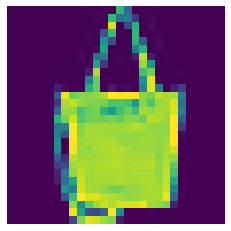

In [3]:
trainData = dset.FashionMNIST(root='./data', download=True,train = True,
                       transform=transforms.Compose([
                           transforms.Resize(28),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]))

testData = dset.FashionMNIST(root='./data', download=True,train = False,
                       transform=transforms.Compose([
                           transforms.Resize(28),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]))
 
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
data = torch.utils.data.ConcatDataset((trainData, testData))
dataloader = DataLoader(data, shuffle=True,batch_size=batch_size)
inputs, classes = next(iter(dataloader))  

#plt.title('Fasion MNIST dataset \n {}'.format(class_names[classes[0]]))
plt.imshow(torch.squeeze(inputs[0]).numpy())
plt.axis('off');

Model

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [5]:
class Generator(nn.Module):
    def __init__(self, nz=128, ngf=128, nc=1):
        super(Generator, self).__init__()
        self.ngf = ngf
        # Layer 1 : FC. Output size - ngf*4*4
        self.Linear = nn.Sequential(
            nn.Linear(in_features = nz, out_features = ngf*4*4, bias=True),
            nn.BatchNorm1d(ngf*4*4),
            nn.ReLU(True))

        # Layer 2 : Output size - ngf*8*8
        self.ConvT1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = ngf, out_channels = ngf, 
            kernel_size = 4,stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True))

        # Layer 3 : Output size - ngf*16*16
        self.ConvT2 =  nn.Sequential(
            nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True))

        # Layer 4 : Output size- ngf*32*32
        self.ConvT3 = nn.Sequential(
            nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True))

        # Layer 5 : Output size- nc*32*32. Increased kernel size to recieve proper image size.
        self.Conv = nn.Sequential(
            nn.Conv2d(ngf,nc, kernel_size=7, stride=1, padding=1, bias=False),
            nn.Tanh())

    def forward(self, z):
       
        out = self.Linear(z)
        out = out.reshape([out.shape[0], self.ngf, 4, 4])
        out = self.ConvT1(out)
        out = self.ConvT2(out)
        out = self.ConvT3(out)
        out = self.Conv(out)
        return out

class Discriminator(nn.Module):
    def __init__(self, ndf, nc=1):
        super(Discriminator, self).__init__()

        # Layer 1 : Output size - ndf*16*16
        self.Conv1 = nn.Sequential(
            nn.Conv2d(nc,ndf, kernel_size=3, stride=2, padding=3, bias=False),
            nn.LeakyReLU(0.2, inplace=True))
        
        # Layer 2 : Output size - ndf*8*8
        self.Conv2 = nn.Sequential(
            nn.Conv2d(ndf,ndf, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True))

        # Layer 3 : Output size - ndf*8*8
        self.Conv3 = nn.Sequential(
            nn.Conv2d(ndf,ndf, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True))

        # Layer 4 : Output size - ndf*8*8
        self.Conv4 = nn.Sequential(
            nn.Conv2d(ndf,ndf, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True))
        
        # Layer 5 : Mean pooling
        self.MeanPool = nn.AvgPool2d(8, stride=1)
        
        self.Linear = nn.Sequential(
            nn.Linear(in_features = ndf, out_features = 1, bias=True),
            nn.Sigmoid())

    def forward(self, input):
       # Input - vector Z with size nz
        out = self.Conv1(input)
        out = self.Conv2(out)
        out = self.Conv3(out)
        out = self.Conv4(out)
        out =  self.MeanPool(out)
        out = np.squeeze(out)
        out = self.Linear(out)
        return out



In [6]:
def Save_Model(_Generator,_Discriminator,nz,epoch,batch_size,master_path,net_type):
    save_path = os.path.join(master_path,net_type)
    if not os.path.isdir(save_path):
        os.mkdir(save_path)
    noise = torch.randn(64, nz, device=device)
    _Generator.eval()
    with torch.no_grad():
      images = _Generator(noise)
      images = images.detach().cpu().numpy().transpose((0, 2, 3, 1))
      images = ((images * 127.5) + 127.5).astype("uint8")
      images = np.repeat(images, 3, axis=-1)
      vis = build_montages(images, (28, 28), (8, 8))[0]
      p = os.path.join(save_path,"epoch_{}.png".format(epoch))
      cv2.imwrite(p, vis)
    _Generator.train()
    torch.save(_Generator.state_dict(),os.path.join(save_path,"epoch_{}_Generator.p".format(epoch) ))
    torch.save(_Discriminator.state_dict(),os.path.join(save_path,"epoch_{}_Discriminator.p".format(epoch)))


In [7]:
def train(criterion, dataloader, D_net, G_net, nz, l_rate, num_iter,net_type,batch_size,clip,clip_value,dec_iter,save_path):

    optimizerD = optim.Adam(D_net.parameters(), lr=l_rate, betas=(0.5, 0.999))
    optimizerG = optim.Adam(G_net.parameters(), lr=l_rate, betas=(0.5, 0.999))

    LossD,LossG = [], []
    print('training for {} epochs'.format(num_iter))

    for epoch in range(num_iter):

        epochLossD, epochLossG = [],[]

        D_net.train()
        G_net.train()
        for batch, data in enumerate(dataloader): 

            # Train discriminator with real image
            D_net.zero_grad()
            real = torch.tensor(data[0],device=device)
            input_size = real.size(0)
            label = torch.full((input_size,1), 1.0, device=device)
            output = D_net(real)

            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            # Train discriminator with fake image
            noise = torch.randn(input_size, nz, device=device)
            fake = G_net(noise)
            label.fill_(0.0)
            output = D_net(fake.detach())
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()

            errD = errD_real + errD_fake
            optimizerD.step()

            D_mean_acc = (1-D_G_z1+D_x)/2.0
            clip_str = 'Without Clipping'
            if clip :  # Clip weights of discriminator
              clip_str = 'With Clipping'
              for p in D_net.parameters():
                  p.data.clamp_(-clip_value, clip_value)

            # Train generator
            if batch % dec_iter == 0:
              G_net.zero_grad()
              label.fill_(1.0) 
              output = D_net(fake)
              errG = criterion(output, label)
              errG.backward()
              D_G_z2 = output.mean().item()
              optimizerG.step()

            epochLossD.append(errD.item())
            epochLossG.append(errG.item())

          

        LossD.append(sum(epochLossD)/len(epochLossD))
        LossG.append(sum(epochLossG)/len(epochLossG))

        print("Epoch %d/%d : discriminator loss: %.2f , generator loss: %.2f, dis acc = %.2f" 
              % (epoch+1,num_iter,float(LossD[-1]),float(LossG[-1]),float(D_mean_acc)))
        
        Save_Model(G_net,D_net,nz,epoch,batch_size,save_path,net_type)
    plt.figure(figsize = (15,7))
    plt.plot(np.arange(len(LossD)), LossD, label='Discriminator loss')
    plt.plot(np.arange(len(LossG)), LossG, label='Generator loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(np.arange(0,len(LossD)-1))
    plt.legend()
    plt.title('{} loss \n {}'.format(net_type,clip_str))
     
    fig_save_path = os.path.join(save_path,net_type)
    plt.savefig(os.path.join(fig_save_path,'{}.jpg'.format(net_type)))
    plt.show()   
    return LossD, LossG


DCGAN Training

training for 20 epochs


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1/20 : discriminator loss: 0.95 , generator loss: 1.20, dis acc = 0.65
Epoch 2/20 : discriminator loss: 0.93 , generator loss: 1.37, dis acc = 0.63
Epoch 3/20 : discriminator loss: 0.94 , generator loss: 1.36, dis acc = 0.63
Epoch 4/20 : discriminator loss: 0.98 , generator loss: 1.33, dis acc = 0.71
Epoch 5/20 : discriminator loss: 0.99 , generator loss: 1.33, dis acc = 0.65
Epoch 6/20 : discriminator loss: 1.01 , generator loss: 1.32, dis acc = 0.61
Epoch 7/20 : discriminator loss: 1.00 , generator loss: 1.33, dis acc = 0.67
Epoch 8/20 : discriminator loss: 0.99 , generator loss: 1.34, dis acc = 0.56
Epoch 9/20 : discriminator loss: 1.00 , generator loss: 1.33, dis acc = 0.63
Epoch 10/20 : discriminator loss: 1.00 , generator loss: 1.33, dis acc = 0.65
Epoch 11/20 : discriminator loss: 1.00 , generator loss: 1.34, dis acc = 0.57
Epoch 12/20 : discriminator loss: 1.00 , generator loss: 1.34, dis acc = 0.61
Epoch 13/20 : discriminator loss: 0.99 , generator loss: 1.36, dis acc = 

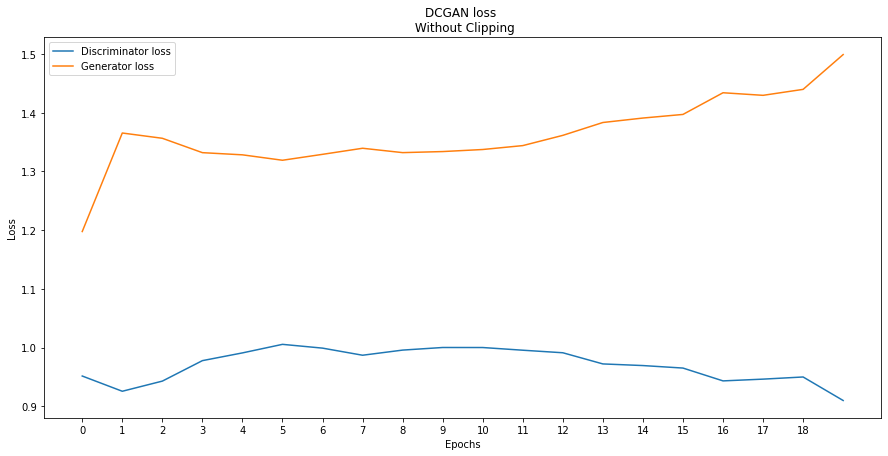

In [8]:
net_str  = 'DCGAN'
save_path = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
G_net_DCGAN = Generator(nz, ngf, nc=1).to(device)
G_net_DCGAN.apply(weights_init)

D_net_DCGAN = Discriminator(ndf, nc=1).to(device)
D_net_DCGAN.apply(weights_init)

dec_iter = 1
clip  = False
clip_value = 0.01

criterion = nn.BCELoss()
loss_DCGAN = train(criterion,dataloader, D_net_DCGAN, G_net_DCGAN, nz, l_rate, epochs,net_str,batch_size,clip,clip_value,dec_iter,save_path)

WGAN Training

training for 20 epochs


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1/20 : discriminator loss: -0.00 , generator loss: -0.50, dis acc = 0.50
Epoch 2/20 : discriminator loss: -0.00 , generator loss: -0.50, dis acc = 0.50
Epoch 3/20 : discriminator loss: -0.00 , generator loss: -0.50, dis acc = 0.50
Epoch 4/20 : discriminator loss: -0.00 , generator loss: -0.50, dis acc = 0.50
Epoch 5/20 : discriminator loss: -0.00 , generator loss: -0.50, dis acc = 0.50
Epoch 6/20 : discriminator loss: -0.00 , generator loss: -0.50, dis acc = 0.50
Epoch 7/20 : discriminator loss: -0.00 , generator loss: -0.50, dis acc = 0.50
Epoch 8/20 : discriminator loss: -0.00 , generator loss: -0.50, dis acc = 0.50
Epoch 9/20 : discriminator loss: -0.00 , generator loss: -0.50, dis acc = 0.50
Epoch 10/20 : discriminator loss: -0.00 , generator loss: -0.50, dis acc = 0.50
Epoch 11/20 : discriminator loss: -0.00 , generator loss: -0.50, dis acc = 0.50
Epoch 12/20 : discriminator loss: -0.00 , generator loss: -0.50, dis acc = 0.50
Epoch 13/20 : discriminator loss: -0.00 , generat

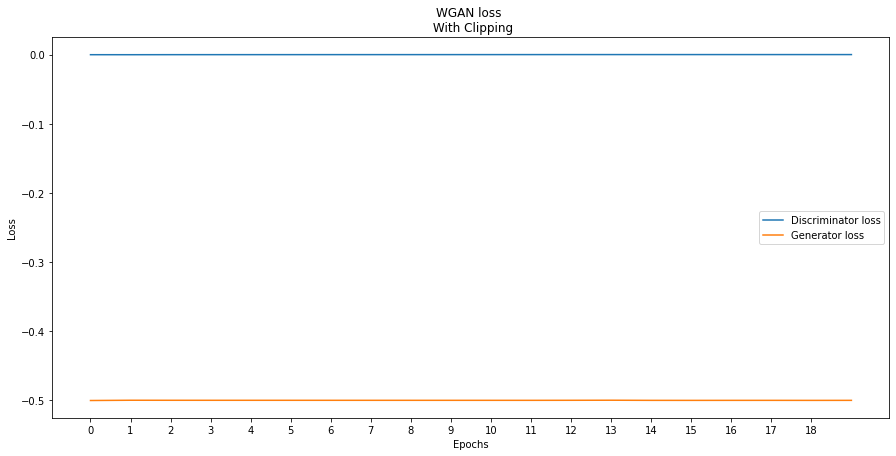

In [9]:
def Wgan_loss(output, label):
    loss = (1-label)*output - label*output 
    return torch.mean(loss)
save_path = os.getcwd()

l_rate_wgan = 5e-5
dec_iter = 1
net_str  = 'WGAN'
IsWgan = 1
clip  = True
clip_value = 0.01

G_net_WGAN = Generator(nz, ngf, nc=1).to(device)
G_net_WGAN.apply(weights_init)

D_net_WGAN= Discriminator(ndf, nc=1).to(device)
D_net_WGAN.apply(weights_init)
criterion = Wgan_loss
loss_WGAN = train(criterion,dataloader, D_net_WGAN, G_net_WGAN, nz, l_rate, epochs,net_str,batch_size,clip,clip_value,dec_iter,save_path)

Model Evaluation

(-0.5, 27.5, 27.5, -0.5)

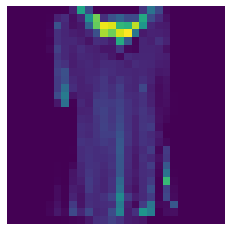

In [19]:
net_str  = 'DCGAN'
load_path = os.getcwd()

G_net_DCGAN = Generator(nz, ngf, nc=1).to(device)
weights_DCGN = torch.load(os.path.join(load_path, '{}_Generator.p'.format(net_str)))
G_net_DCGAN.load_state_dict(weights_DCGN)
noise = torch.randn(1, nz, device=device)

G_net_DCGAN.eval()
with torch.no_grad():
  fake_DCGAN = G_net_DCGAN(noise)
im = fake_DCGAN.detach().cpu().numpy()
plt.imshow(np.squeeze(im));
plt.axis('off')


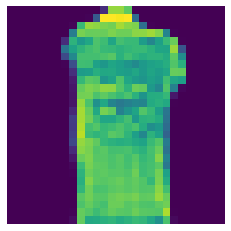

In [26]:
net_str  = 'WGAN'
load_path = os.getcwd()

G_net_WGAN = Generator(nz, ngf, nc=1).to(device)
weights_WGAN = torch.load(os.path.join(load_path, '{}_Generator.p'.format(net_str)))
G_net_WGAN.load_state_dict(weights_WGAN)
noise = torch.randn(1, nz, device=device)

G_net_WGAN.eval()
with torch.no_grad():
  fake_WGAN = G_net_WGAN(noise)
im = fake_WGAN.detach().cpu().numpy()
plt.imshow(np.squeeze(im))
plt.axis('off');
